# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Важно:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* `Price` — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import spacy
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [7]:
def rename_column(column_name):
    new_column_name = ''
    for letter in column_name:
        if letter.lower() != letter and len(new_column_name) != 0:
            new_column_name += '_' + letter.lower()
        else:
            new_column_name += letter.lower()
    return(new_column_name)

In [8]:
new_columns = []
for column in data.columns:
    new_columns.append(rename_column(column))
data.columns = new_columns
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [9]:
data['date_crawled'] = pd.to_datetime(
    data['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
data['date_created'] = pd.to_datetime(
    data['date_created'], format='%Y-%m-%dT%H:%M:%S')
data['last_seen'] = pd.to_datetime(
    data['last_seen'], format='%Y-%m-%dT%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [10]:
data.duplicated().sum()

4

In [11]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [12]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [13]:
data = data.fillna('unknown')
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

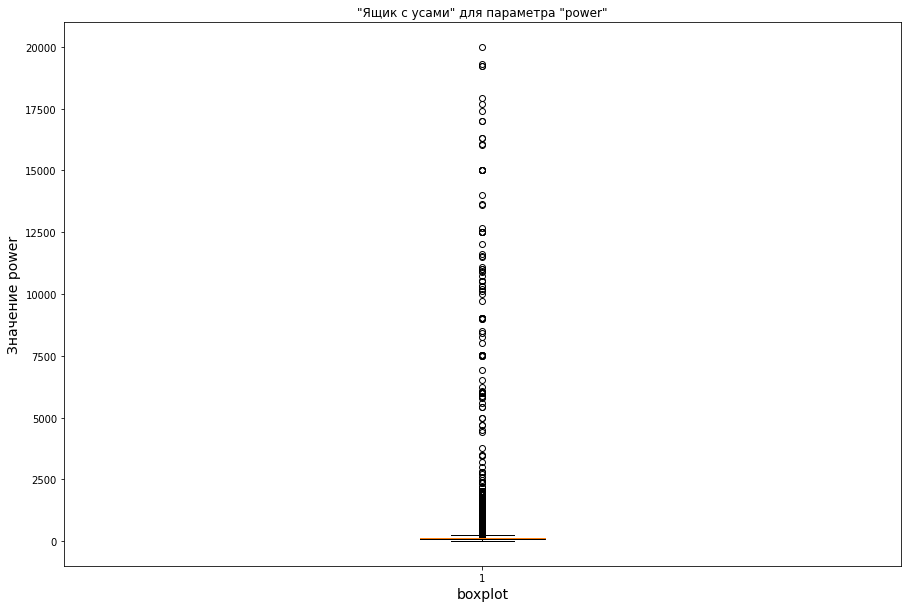

In [14]:
plt.title('"Ящик с усами" для параметра "power"')
plt.ylabel('Значение power', size=14)
plt.xlabel('boxplot', size=14)
plt.boxplot(data['power']);

In [15]:
data['power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [16]:
data['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [17]:
data = data[(data['power'] > 59) & (data['power'] < 300)]

count    286863.000000
mean        123.259556
std          46.346035
min          60.000000
25%          90.000000
50%         116.000000
75%         150.000000
max         299.000000
Name: power, dtype: float64

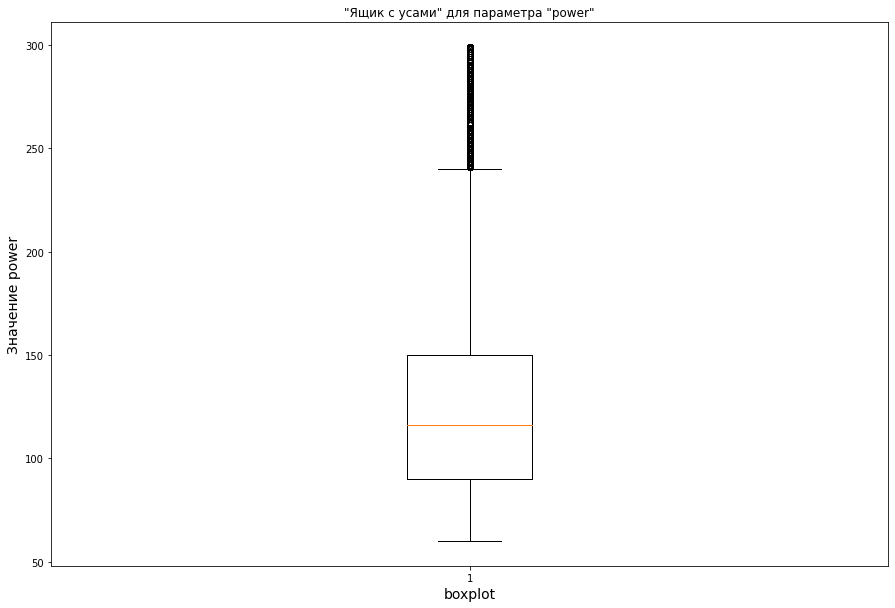

In [18]:
display(data['power'].describe())
plt.title('"Ящик с усами" для параметра "power"')
plt.ylabel('Значение power', size=14)
plt.xlabel('boxplot', size=14)
plt.boxplot(data['power']);

In [19]:
data['price'].describe()

count    286863.000000
mean       4890.860006
std        4581.857608
min           0.000000
25%        1400.000000
50%        3300.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64

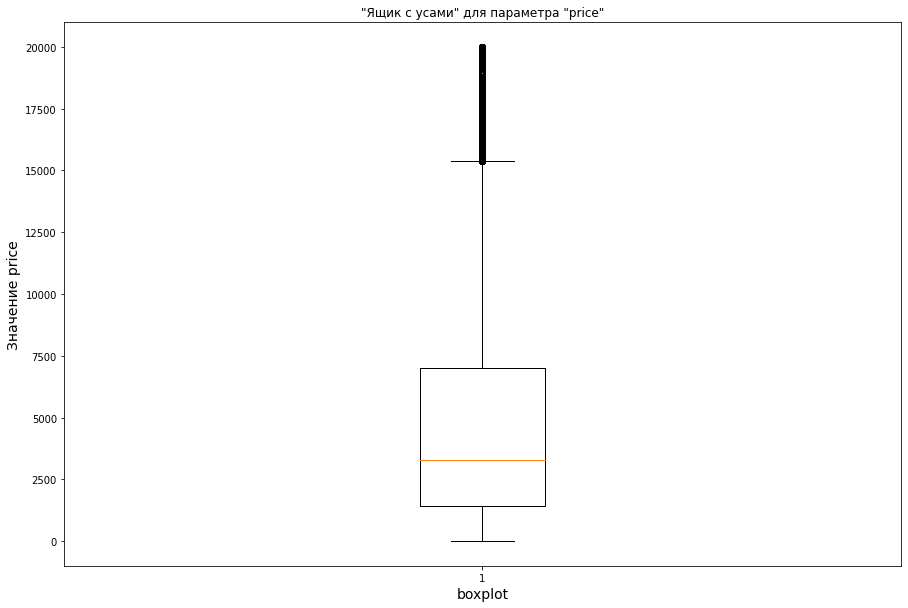

In [20]:
plt.title('"Ящик с усами" для параметра "price"')
plt.ylabel('Значение price', size=14)
plt.xlabel('boxplot', size=14)
plt.boxplot(data['price']);

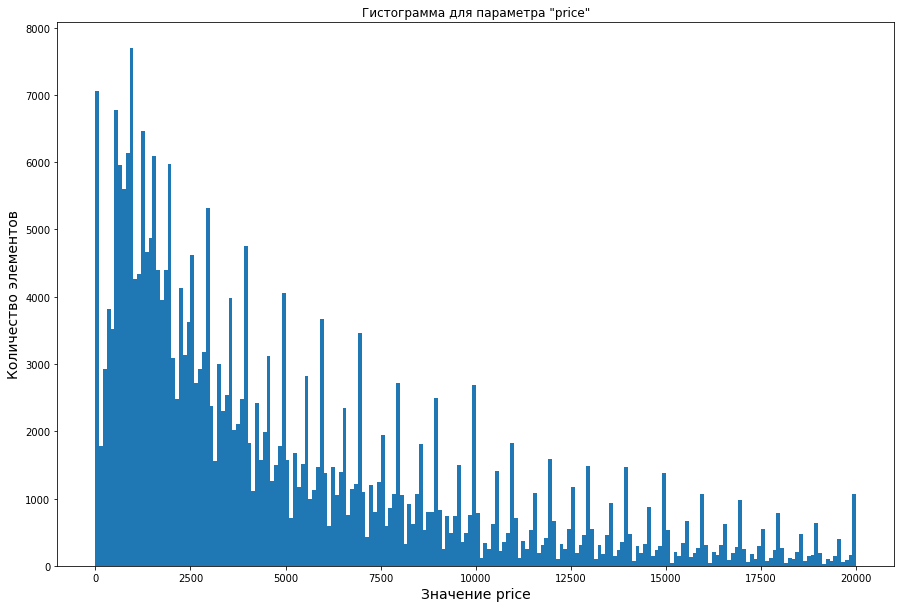

In [21]:
plt.title('Гистограмма для параметра "price"')
plt.xlabel('Значение price', size=14)
plt.ylabel('Количество элементов', size=14)
plt.hist(data['price'], bins=200);

In [22]:
data = data[(data['price'] > 300) & (data['price'] < 15400)]

count    260585.000000
mean       4505.167730
std        3708.989905
min         301.000000
25%        1500.000000
50%        3300.000000
75%        6600.000000
max       15399.000000
Name: price, dtype: float64

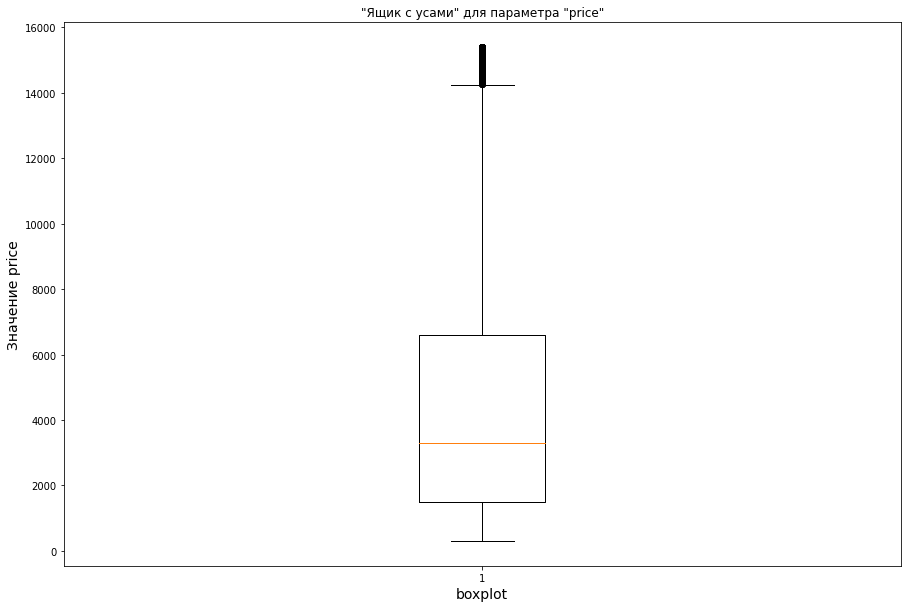

In [23]:
display(data['price'].describe())
plt.title('"Ящик с усами" для параметра "price"')
plt.ylabel('Значение price', size=14)
plt.xlabel('boxplot', size=14)
plt.boxplot(data['price']);

In [24]:
display(data['registration_year'].sort_values().unique())
data['registration_month'].sort_values().unique()

array([1000, 1500, 1800, 1910, 1937, 1942, 1943, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2800, 2900, 4500, 5000, 5911, 8200, 9999])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [25]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39


In [26]:
data = data[(data['registration_year'] >= 1937) & (data['registration_year'] <= data['date_crawled'].max().year) 
            & (data['registration_month'] != 0)]

In [71]:
data['number_of_pictures'].sort_values().unique()

array([0])

        Даты непригодны для обучения модели, поэтому их необходимо удалить. В столбце "number_of_pictures" все значения 
    равны 0, поэтому этот столбец не имеет никакого значения, его тоже необходимо удалить. Столбцы "postal_code" и 
    "registration_month" не несут никакой информации для обучения модели, их тоже необходимо удалить.

In [72]:
columns_to_drop = ['price', 'date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'postal_code', 
                   'registration_month']
features = data.drop(columns_to_drop, axis=1)

In [73]:
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print('Размеры и размерности выборок:', features_train.shape, features_valid.shape, features_test.shape)

Размеры и размерности выборок: (142643, 9) (47548, 9) (47548, 9)


In [74]:
pd.options.mode.chained_assignment = None
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [75]:
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
features_train[categorical_columns] = encoder.fit_transform(features_train[categorical_columns])
features_valid[categorical_columns] = encoder.transform(features_valid[categorical_columns])
features_test[categorical_columns] = encoder.transform(features_test[categorical_columns])

display(features_valid.head())
display(features_test.head())

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
52550,4.0,1999,1.0,101,115.0,150000,6.0,38.0,0.0
350314,4.0,1997,0.0,101,232.0,100000,6.0,24.0,0.0
46089,4.0,2003,1.0,192,15.0,150000,6.0,2.0,1.0
72023,8.0,1999,1.0,116,102.0,150000,6.0,10.0,1.0
213097,8.0,2001,0.0,163,58.0,150000,6.0,20.0,0.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
57853,7.0,2012,1.0,110,118.0,50000,6.0,12.0,0.0
238033,4.0,2003,1.0,97,186.0,90000,6.0,15.0,0.0
157209,4.0,1999,1.0,101,217.0,150000,6.0,30.0,2.0
49250,5.0,2003,1.0,98,36.0,150000,4.0,23.0,0.0
109527,0.0,1994,1.0,68,221.0,150000,2.0,38.0,0.0


In [76]:
numerical_columns = features.columns.drop(categorical_columns)

scaler = StandardScaler()
scaler.fit(features_train[numerical_columns])

features_train_numerical = pd.DataFrame(scaler.transform(features_train[numerical_columns]), columns=numerical_columns,
                                       index=features_train[numerical_columns].index)
features_train = pd.concat([features_train_numerical, features_train[categorical_columns]], axis=1)


features_valid_numerical = pd.DataFrame(scaler.transform(features_valid[numerical_columns]), columns=numerical_columns,
                                       index=features_valid[numerical_columns].index)
features_valid = pd.concat([features_valid_numerical, features_valid[categorical_columns]], axis=1)


features_test_numerical = pd.DataFrame(scaler.transform(features_test[numerical_columns]), columns=numerical_columns,
                                       index=features_test[numerical_columns].index)
features_test = pd.concat([features_test_numerical, features_test[categorical_columns]], axis=1)



display(features_valid.head())
display(features_test.head())

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
52550,-0.688697,-0.470662,0.574334,4.0,1.0,115.0,6.0,38.0,0.0
350314,-1.025407,-0.470662,-0.848897,4.0,0.0,232.0,6.0,24.0,0.0
46089,-0.015277,1.553538,0.574334,4.0,1.0,15.0,6.0,2.0,1.0
72023,-0.688697,-0.137002,0.574334,8.0,1.0,102.0,6.0,10.0,1.0
213097,-0.351987,0.908464,0.574334,8.0,0.0,58.0,6.0,20.0,0.0


,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
57853,1.499918,-0.270466,-2.272127,7.0,1.0,118.0,6.0,12.0,0.0
238033,-0.015277,-0.559637,-1.133543,4.0,1.0,186.0,6.0,15.0,0.0
157209,-0.688697,-0.470662,0.574334,4.0,1.0,217.0,6.0,30.0,2.0
49250,-0.015277,-0.537394,0.574334,5.0,1.0,36.0,4.0,23.0,0.0
109527,-1.530473,-1.204712,0.574334,0.0,1.0,221.0,2.0,38.0,0.0


        Данные были считаны в переменную data. В трех столбцах изменен тип данных на datetime. Обнаружено и удалено 4
     дубликата. Заполнены пропуски значением "unknown". В столбцах power, price, registration_year и registration_month 
     найдены и удалены аномальные значения. Удалены столбцы с датами и столбец "number_of_pictures", так как они не подходят 
     для обучения модели. Данные разделены на обучающую, валидационную и тестовую выборки, в соотношении  3:1:1. 
     Категориальные признаки закодированы, данные стандартизированы. 

## Обучение моделей

In [77]:
%%time
best_rmse = -1
for depth in [None] + [i for i in range(2, 7)]:
    for estimators in range(40, 60, 10):
        model = LGBMRegressor(max_depth=depth, learning_rate=0.2, n_estimators=estimators, random_state=12345)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predict)**0.5
        if best_rmse == -1 or rmse < best_rmse:
            best_depth = depth
            best_estimators = estimators
            best_rmse = rmse
        print(f'Глубина: {depth} Количество деревьев: {estimators} Значение RMSE: {rmse:.1f}')
print(f'Лучшая глубина: {best_depth} Лучшее количество деревьев: {best_estimators} Лучшее значение RMSE: {best_rmse:.1f}')

Глубина: None Количество деревьев: 40 Значение RMSE: 1481.5
Глубина: None Количество деревьев: 50 Значение RMSE: 1462.4
Глубина: 2 Количество деревьев: 40 Значение RMSE: 1811.5
Глубина: 2 Количество деревьев: 50 Значение RMSE: 1767.2
Глубина: 3 Количество деревьев: 40 Значение RMSE: 1664.0
Глубина: 3 Количество деревьев: 50 Значение RMSE: 1632.3
Глубина: 4 Количество деревьев: 40 Значение RMSE: 1577.0
Глубина: 4 Количество деревьев: 50 Значение RMSE: 1553.3
Глубина: 5 Количество деревьев: 40 Значение RMSE: 1520.5
Глубина: 5 Количество деревьев: 50 Значение RMSE: 1499.4
Глубина: 6 Количество деревьев: 40 Значение RMSE: 1498.3
Глубина: 6 Количество деревьев: 50 Значение RMSE: 1476.3
Лучшая глубина: None Лучшее количество деревьев: 50 Лучшее значение RMSE: 1462.4
CPU times: user 15min 26s, sys: 4.86 s, total: 15min 31s
Wall time: 15min 39s


In [78]:
%%time
best_rmse = -1
for depth in [None] + [i for i in range(2, 7)]:
    for iterations in range(700, 850, 50):
        model = CatBoostRegressor(depth=depth, learning_rate=0.2, iterations=iterations, silent=True, random_state=12345)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predict)**0.5
        if best_rmse == -1 or rmse <= best_rmse:
            best_depth = depth
            best_iterations = iterations
            best_rmse = rmse
        print(f'Глубина: {depth} Количество итераций: {iterations} Значение RMSE: {rmse:.1f}')
print(f'Лучшая глубина: {best_depth} Лучшее количество итераций: {best_iterations} Лучшее значение RMSE: {best_rmse:.1f}')

Глубина: None Количество итераций: 700 Значение RMSE: 1370.3
Глубина: None Количество итераций: 750 Значение RMSE: 1368.1
Глубина: None Количество итераций: 800 Значение RMSE: 1366.5
Глубина: 2 Количество итераций: 700 Значение RMSE: 1531.1
Глубина: 2 Количество итераций: 750 Значение RMSE: 1526.8
Глубина: 2 Количество итераций: 800 Значение RMSE: 1524.0
Глубина: 3 Количество итераций: 700 Значение RMSE: 1452.9
Глубина: 3 Количество итераций: 750 Значение RMSE: 1449.6
Глубина: 3 Количество итераций: 800 Значение RMSE: 1446.7
Глубина: 4 Количество итераций: 700 Значение RMSE: 1414.6
Глубина: 4 Количество итераций: 750 Значение RMSE: 1411.2
Глубина: 4 Количество итераций: 800 Значение RMSE: 1408.1
Глубина: 5 Количество итераций: 700 Значение RMSE: 1388.9
Глубина: 5 Количество итераций: 750 Значение RMSE: 1385.5
Глубина: 5 Количество итераций: 800 Значение RMSE: 1382.8
Глубина: 6 Количество итераций: 700 Значение RMSE: 1370.3
Глубина: 6 Количество итераций: 750 Значение RMSE: 1368.1
Глуби

In [79]:
%%time
best_rmse = -1
for depth in [None] + [i for i in range(2, 7)]:
    for est in range(40, 60, 10):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predict)**0.5
        if best_rmse == -1 or rmse < best_rmse:
            best_depth = depth
            best_est = est
            best_rmse = rmse
        print(f'Глубина: {depth} Количество деревьев: {est} Значение RMSE: {rmse:.1f}')
print(f'Лучшая глубина: {best_depth} Лучшее количество деревьев: {best_est} Лучшее значение RMSE: {best_rmse:.1f}')

Глубина: None Количество деревьев: 40 Значение RMSE: 1404.1
Глубина: None Количество деревьев: 50 Значение RMSE: 1401.2
Глубина: 2 Количество деревьев: 40 Значение RMSE: 2644.4
Глубина: 2 Количество деревьев: 50 Значение RMSE: 2635.0
Глубина: 3 Количество деревьев: 40 Значение RMSE: 2418.8
Глубина: 3 Количество деревьев: 50 Значение RMSE: 2415.9
Глубина: 4 Количество деревьев: 40 Значение RMSE: 2152.8
Глубина: 4 Количество деревьев: 50 Значение RMSE: 2148.7
Глубина: 5 Количество деревьев: 40 Значение RMSE: 2014.9
Глубина: 5 Количество деревьев: 50 Значение RMSE: 2011.5
Глубина: 6 Количество деревьев: 40 Значение RMSE: 1910.8
Глубина: 6 Количество деревьев: 50 Значение RMSE: 1908.7
Лучшая глубина: None Лучшее количество деревьев: 50 Лучшее значение RMSE: 1401.2
CPU times: user 1min 8s, sys: 310 ms, total: 1min 8s
Wall time: 1min 8s


In [80]:
%%time
random_forest_model = RandomForestRegressor(n_estimators=50, max_depth=None, random_state=12345)
random_forest_model.fit(features_train, target_train)

CPU times: user 16 s, sys: 37.5 ms, total: 16 s
Wall time: 16 s


RandomForestRegressor(n_estimators=50, random_state=12345)

In [81]:
%%time
predict = random_forest_model.predict(features_valid)
rmse = mean_squared_error(target_valid, predict)**0.5
print(f'Значение RMSE для модели RandomForestRegressor: {rmse:.1f}')

Значение RMSE для модели RandomForestRegressor: 1401.2
CPU times: user 898 ms, sys: 0 ns, total: 898 ms
Wall time: 902 ms


In [82]:
%%time
cat_boost_model = CatBoostRegressor(depth=6, learning_rate=0.2, iterations=800, silent=True, random_state=12345)
cat_boost_model.fit(features_train, target_train)

CPU times: user 15.8 s, sys: 75.3 ms, total: 15.9 s
Wall time: 16.8 s


In [83]:
%%time
predict = cat_boost_model.predict(features_valid)
rmse = mean_squared_error(target_valid, predict)**0.5
print(f'Значение RMSE для модели CatBoostRegressor: {rmse:.1f}')

Значение RMSE для модели CatBoostRegressor: 1366.5
CPU times: user 33.6 ms, sys: 8.21 ms, total: 41.8 ms
Wall time: 39.3 ms


In [84]:
%%time
lgbm_model = LGBMRegressor(max_depth=None, learning_rate=0.2, n_estimators=50, random_state=12345)
lgbm_model.fit(features_train, target_train)

CPU times: user 2min 56s, sys: 975 ms, total: 2min 57s
Wall time: 2min 59s


LGBMRegressor(learning_rate=0.2, max_depth=None, n_estimators=50,
              random_state=12345)

In [85]:
%%time
predict = lgbm_model.predict(features_valid)
rmse = mean_squared_error(target_valid, predict)**0.5
print(f'Значение RMSE для модели LGBMRegressor: {rmse:.1f}')

Значение RMSE для модели LGBMRegressor: 1462.4
CPU times: user 227 ms, sys: 21 µs, total: 227 ms
Wall time: 283 ms


        Было изучено 3 модели: LGBMRegressor, CatBoostRegressor и RandomForestRegressor. Для каждой модели найдены
     лучшие параметры. Найдены значения RMSE на валидационной выборке для каждой модели. Также измерены скорости обучения и
     предсказания, данные готовы к анализу.

## Анализ моделей

        Результаты исследования представлены ниже. Исходя из них, можно сказать, что самая качественная и самая быстрая в
    предсказании модель CatBoostRegressor, скорость предсказания моделей RandomForestRegressor и CatBoostRegressor примерно
    одинаковая.
        Итог: выбрана модель CatBoostRegressor, проведем тестирование на тестовой выборке.

| Модель | Значение RMSE | Скорость обучения | Скорость предсказания |
| --- | --- | --- | --- |
| RandomForestRegressor | 1401.2 | 16 s | 902 ms |
| CatBoostRegressor | 1366.5 | 16.8 s | 39.3 ms |
| LGBMRegressor | 1462.4 | 2min 59s | 283 ms | 

In [86]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [87]:
%%time
cat_boost_model = CatBoostRegressor(depth=6, learning_rate=0.2, iterations=800, silent=True, random_state=12345)
cat_boost_model.fit(features_train, target_train);

CPU times: user 22 s, sys: 144 ms, total: 22.1 s
Wall time: 23.1 s


In [88]:
%%time
predict = cat_boost_model.predict(features_test)
rmse = mean_squared_error(target_test, predict)**0.5
print(f'Значение RMSE для модели CatBoostRegressor: {rmse:.1f}')

Значение RMSE для модели CatBoostRegressor: 1372.8
CPU times: user 58.4 ms, sys: 0 ns, total: 58.4 ms
Wall time: 56.7 ms


In [89]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_predicted = dummy_regr.predict(features_test)
dummy_rmse = mean_squared_error(target_test, dummy_predicted)**0.5
print('Значение RMSE для модели DummyRegressor:', dummy_rmse)

Значение RMSE для модели DummyRegressor: 3756.5087749590743


            Обученные модели с наилучшими параметрами проанализированы. В результате наилучшая модель по значению RMSE и
        по скорости обучения - CatBoostRegressor, поэтому данная модель является оптимальным выбором. Проведена проверка
        модели на адекватность с помощью модели DummyRegressor, в качестве предсказания которой среднее значение.
            В итоге наилучшая модель, CatBoostRegresssor, имеет следующие результаты на тестовой выборке. 

| Значение RMSE | Скорость обучения | Скорость предсказания |
| --- | --- | --- |
| 1372.8 | 23.1 s | 56.7 ms |

# Вывод
## Подготовка данных
    
    - Данные считаны и записаны в переменную data;
    - В трех столбцах изменен тип данных на datetime;
    - Обнаружено и удалено 4 дубликата;
    - Заполнены пропуски значением "unknown";
    - В столбцах power, price, registration_year и registration_month найдены и удалены аномальные значения;
    - Удалены столбцы с датами и столбцы "number_of_pictures", "postal_code" и "registration_month", так как они не подходят 
    для обучения модели;
    - Данные разделены на 3 выборки в соотношении 3:1:1;
    - Категориальные признаки закодированы, данные стандартизированы.
## Обучение моделей

    - В исследовании задействованы 3 модели: LGBMRegressor, CatBoostRegressor и RandomForestRegressor;
    - Для каждой модели найдены лучшие параметры обучения;
    - Найдены значения RMSE на валидационной выборке для каждой модели;
    - Измерена скорость обучения моделей;
    - Измерена скорость предсказания моделей, данные готовы к анализу.

## Построение и выбор наилучшей модели
    - В ходе исследования получены следующие данные:
| Модель | Значение RMSE | Скорость обучения | Скорость предсказания |
| --- | --- | --- | --- |
| RandomForestRegressor | 1401.2 | 16 s | 902 ms |
| CatBoostRegressor | 1366.5 | 16.8 s | 39.3 ms |
| LGBMRegressor | 1462.4 | 2min 59s | 283 ms | 
    
    - Обученные модели с наилучшими параметрами проанализированы;
    - Наилучшая модель по значению RMSE - CarBoostRegressor, значение RMSE равно 1381.9;
    - Скорость обучения моделей CarBoostRegressor и RandomForestRegressor примерно одинаковая;
    - Наилучшая модель по скорости предсказания - CatBoostRegressor, время предсказания составило 42 ms;
    - CatBoostRegressor является оптимальным выбором;
    - Проведена проверка на адекватность с помощью модели DummyRegressor, в качестве предсказания которой среднее значение;
    - CatBoostRegressor обучена на обучающей и валидационной выборках и проверена на тестовой выборке, результаты 
    исследования данной моделе следующие:
    
| Значение RMSE | Скорость обучения | Скорость предсказания |
| --- | --- | --- |
| 1372.8 | 23.1 s | 56.7 ms |